In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import os, sys

# sys.path.append("~/X/PythonForDataScience/air_traffic_project/submissions/first_real_submission/")

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from problem import *
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
import geopy.distance
from sklearn.metrics import mean_squared_error
from model_selection_python import *
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance


from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os

from estimator_all_features import _merge_external_data
# from estimator import _merge_external_data

from keras.wrappers.scikit_learn import KerasRegressor

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from keras.metrics import RootMeanSquaredError

from xgboost import XGBRegressor, XGBRFRegressor
import xgboost as xgb


pd.set_option('display.max_columns', None)

In [2]:
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials


class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgbrf_reg(self, para):
        reg = xgb.XGBRFRegressor(**para['reg_params'])
        return self.train_reg(reg, para)
    
    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def lgb_reg(self, para):
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def ctb_reg(self, para):
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}

def power_2(x):
    return np.power(x, 2)

def inv_fct(x):
    return 1/x

## Loading Data

In [3]:
X_train, y_train = get_train_data('..')
X_test, y_test = get_test_data('..')

X_train_merged = _merge_external_data(X_train)
X_test_merged = _merge_external_data(X_test)

/Users/maxime/X/PythonForDataScience/air_traffic_project/src/estimator_all_features.py:31: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  X_encoded.loc[:, 'week'] = X_encoded['DateOfDeparture'].dt.week


In [4]:
X_train_merged.columns

Index(['Departure', 'Arrival', 'WeeksToDeparture', 'std_wtd',
       'Days_to_departure', 'route_mean', 'year_departure', 'day_departure',
       'n_days_departure', 'day_nb_mean', 'day_mean', 'week_mean',
       'month_mean', 'oil_stock_price', 'oil_stock_volume', 'AAL_stock_price',
       'AAL_stock_volume', 'SP_stock_price', 'SP_stock_volume',
       'Max TemperatureC_dep', 'Mean TemperatureC_dep', 'Min TemperatureC_dep',
       'Dew PointC_dep', 'MeanDew PointC_dep', 'Min DewpointC_dep',
       'Max Humidity_dep', 'Mean Humidity_dep', 'Min Humidity_dep',
       'Max Sea Level PressurehPa_dep', 'Mean Sea Level PressurehPa_dep',
       'Min Sea Level PressurehPa_dep', 'Max VisibilityKm_dep',
       'Mean VisibilityKm_dep', 'Min VisibilitykM_dep',
       'Max Wind SpeedKm/h_dep', 'Mean Wind SpeedKm/h_dep', 'CloudCover_dep',
       'WindDirDegrees_dep', 'LoadFactorDomestic_dep',
       'PassengersDomestic_dep', 'latitude_deg_dep', 'longitude_deg_dep',
       'pop2010_dep', 'Unemploymen

In [5]:
X_train_merged.columns[X_train_merged.isna().any()].tolist()

[]

In [6]:
X_train_data = X_train_merged
X_test_data = X_test_merged

X_train_data.drop(['holidays_dep', 'holidays_arr', 'Departure', 'Arrival'], axis=1, inplace=True)
X_test_data.drop(['holidays_dep', 'holidays_arr', 'Departure', 'Arrival'], axis=1, inplace=True)

## Defining Model

In [7]:
from hyperopt import hp

# XGB parameters
xgb_reg_params = {
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.025)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(7000, 10000, 1000)),
#     'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart'])
}
xgb_fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
# xgb_para['learning_rate'] = 0.075
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

# Feature Engineering STD_WTD
X_train_data['std_wtd_log'] = X_train_data['std_wtd'].transform(np.log)
X_train_data['std_wtd_inv'] = X_train_data['std_wtd'].transform(inv_fct)
# X_train_data['std_wtd_logsqrt'] = X_train_data['std_wtd_log'].transform(np.sqrt)

# X_train_data['std_wtd_log_poly'] = X_train_data['std_wtd'].transform(power_2) + X_train_data['std_wtd']

# X_train_data['std_wtd_log10'] = X_train_data['std_wtd'].transform(np.log10)
# X_train_data['std_wtd_exp'] = X_train_data['std_wtd'].transform(np.exp)
# X_train_data['std_wtd_sqrt'] = X_train_data['std_wtd'].transform(np.sqrt)
# X_train_data['std_wtd_power2'] = X_train_data['std_wtd'].transform(power_2)
# print(X_train_data.head())

X_test_data['std_wtd_log'] = X_test_data['std_wtd'].transform(np.log)
X_test_data['std_wtd_inv'] = X_test_data['std_wtd'].transform(inv_fct)

obj = HPOpt(X_train_data, X_test_data, y_train, y_test)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)


100%|██████████| 100/100 [13:45<00:00,  8.26s/trial, best loss: 0.32567926732067715]


In [8]:
results, trials = xgb_opt

In [9]:
results

{'colsample_bytree': 2,
 'learning_rate': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 0,
 'subsample': 0.9756178193031197}

### Results of GS params 200 - 350 trees:

    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.025)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(200, 350, 50)),
    
{'colsample_bytree': 1,
 'learning_rate': 0,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 2,
 'subsample': 0.9845524734902599}
 
 RMSE = 0.3318791717769364
 
 xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.05, 
                          n_estimators=300, max_depth=10, min_child_weight=4, subsample=0.984, booster='gbtree')
 
 RMSE =0.3311

### Results of GS params 5000 - trees:

    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.025)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.5, 1.0, 0.1)),
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(7000, 10000, 1000)),
    
{'colsample_bytree': 2,
 'learning_rate': 0,
 'max_depth': 3,
 'min_child_weight': 3,
 'n_estimators': 0,
 'subsample': 0.9756178193031197}
 
 RMSE = 0.32567926732067715
 
 Attempt 1:
 xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.05, 
                          n_estimators=7000, max_depth=8, min_child_weight=5, subsample=0.9756178193031197, booster='gbtree')
 
 RMSE = 0.324221
 
 Attempt 2:
 xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.03, 
                          n_estimators=7000, max_depth=8, min_child_weight=5, subsample=0.9756178193031197, booster='gbtree')
 
 RMSE = 0.320454
 
 Attempt 3:
 xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.01, 
                          n_estimators=7000, max_depth=8, min_child_weight=5, subsample=0.9756178193031197, booster='gbtree')
 
 RMSE = 0.318995

## Testing on one XGBoost

RMSE: 0.318995


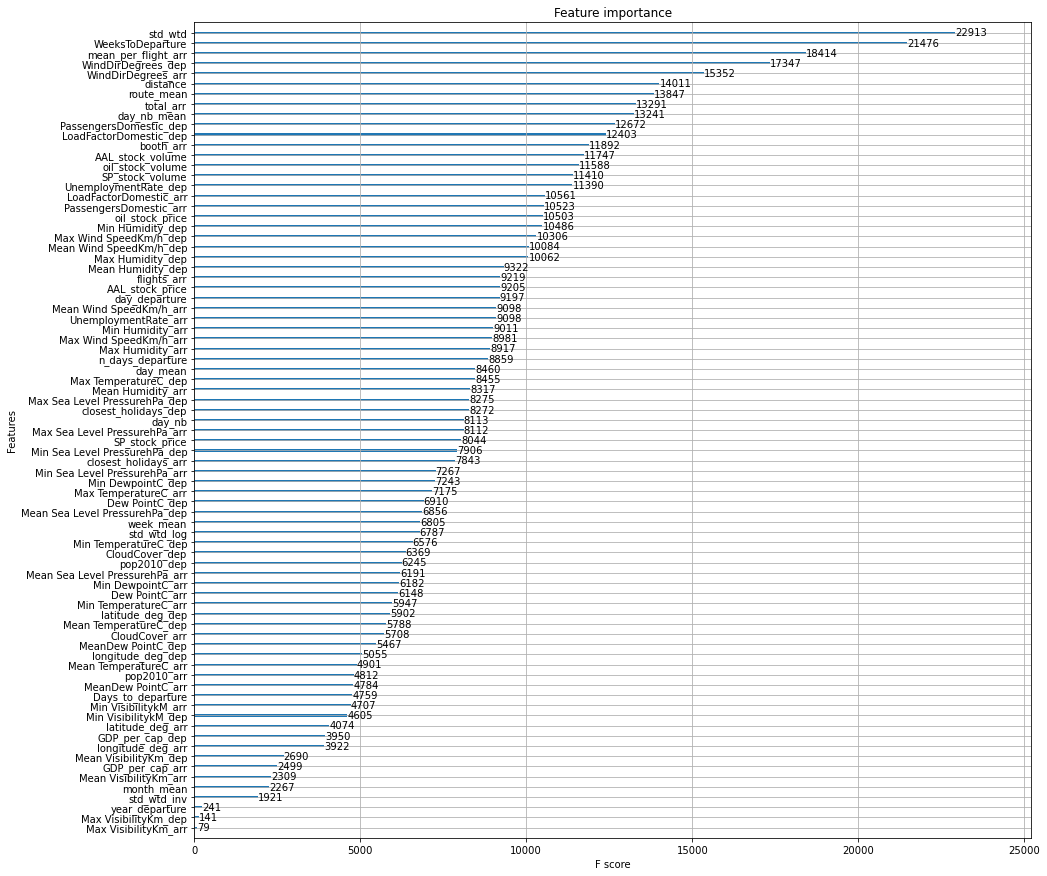

In [12]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.7, learning_rate=0.01, 
                          n_estimators=7000, max_depth=8, min_child_weight=5, subsample=0.9756178193031197, 
                          booster='gbtree')

xg_reg.fit(X_train_data, y_train)

preds = xg_reg.predict(X_test_data)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

plt.rcParams['figure.figsize'] = [15, 15]
xgb.plot_importance(xg_reg)
plt.show()